# Intuit / Quicken Quickbooks Group Assignment
Class: Marketing Analytics (EWMBA263 -1)
Team: Albert Deng, Peter Pang, Alex Im, and DJ Prahladka

## 0. Data Initialization

Import data and look at the variables available

In [1]:
import pandas
import shared.mba263 as mba263
import matplotlib.pyplot as plt
import numpy as np

data = pandas.read_csv('shared/intuit.csv')
data.head(10)

,id,sex,bizflag,zip,zip_bins,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1
0,1,U,1,99999,20,1,129.5,11,1,0,0,0,0
1,2,U,1,99999,20,2,65.0,4,14,0,0,0,0
2,3,U,1,99999,20,1,24.5,13,36,1,0,0,0
3,4,U,1,99999,20,1,80.5,5,19,1,0,0,0
4,5,U,1,99999,20,1,111.0,14,7,0,0,0,0
5,6,U,1,99999,20,1,61.5,14,20,0,0,1,0
6,7,U,1,99999,20,1,56.0,5,27,0,0,1,0
7,8,U,1,99999,20,1,39.5,4,2,0,0,0,0
8,9,U,1,99999,20,1,22.0,17,1,0,0,0,1
9,10,U,1,99999,20,2,113.0,7,15,0,0,0,0


In [2]:
data.describe()

,id,bizflag,zip,zip_bins,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1
count,20000.000000,20000.000000,20000.0000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.244400,54350.2613,10.499000,2.079450,93.581000,15.779650,15.751400,0.208250,0.027100,0.215600,0.048050
std,5773.647028,0.429742,32776.4059,5.766755,1.246361,82.601398,9.527331,10.020435,0.406067,0.162379,0.411248,0.213877
min,1.000000,0.000000,0.0000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,5000.750000,0.000000,23451.0000,5.000000,1.000000,37.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,10000.500000,0.000000,55402.5000,10.500000,2.000000,71.000000,15.000000,15.000000,0.000000,0.000000,0.000000,0.000000
75%,15000.250000,0.000000,89018.7500,15.250000,3.000000,124.500000,24.000000,24.000000,0.000000,0.000000,0.000000,0.000000
max,20000.000000,1.000000,99999.0000,20.000000,5.000000,937.500000,36.000000,36.000000,1.000000,1.000000,1.000000,1.000000


## 1. Data Selection and Analysis
### a) Data Transformation

Add additional variables and define scope for evaluation

In [3]:
# Add transformational ordinal and indicator variables
data = pandas.get_dummies(data, columns=['sex'])

# Explore variable correlation
data.corr()

,id,bizflag,zip,zip_bins,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,sex_B,sex_F,sex_M,sex_U
id,1.000000,0.019549,0.951592,0.950288,0.011851,0.002533,-0.008602,-0.004941,-0.010066,0.003038,-0.002295,-0.067746,-0.009454,0.042165,-0.042447,0.010227
bizflag,0.019549,1.000000,0.020482,0.019832,0.004448,-0.002881,0.001381,0.000281,-0.003704,0.005399,0.004286,-0.012441,-0.026705,0.012127,-0.236845,0.321975
zip,0.951592,0.020482,1.000000,0.991646,0.010041,-0.000290,-0.012345,-0.003814,-0.009068,0.007811,-0.000025,-0.066572,-0.013720,0.034798,-0.042820,0.020208
zip_bins,0.950288,0.019832,0.991646,1.000000,0.010408,0.000031,-0.011061,-0.004327,-0.010363,0.008039,0.000302,-0.066915,-0.010725,0.034556,-0.044303,0.022168
numords,0.011851,0.004448,0.010041,0.010408,1.000000,0.583424,-0.135637,0.010710,0.002775,0.116107,0.015454,0.085845,-0.007275,0.001598,-0.004697,0.005688
dollars,0.002533,-0.002881,-0.000290,0.000031,0.583424,1.000000,-0.081646,0.000722,0.001370,0.079956,0.008115,0.068543,-0.002152,0.003290,0.000137,-0.003853
last,-0.008602,0.001381,-0.012345,-0.011061,-0.135637,-0.081646,1.000000,0.010799,-0.001412,-0.018021,0.004507,-0.100100,0.015536,0.003174,-0.002707,-0.002173
sincepurch,-0.004941,0.000281,-0.003814,-0.004327,0.010710,0.000722,0.010799,1.000000,0.516243,0.001559,0.517050,0.076105,-0.003521,0.001968,-0.011012,0.013596
version1,-0.010066,-0.003704,-0.009068,-0.010363,0.002775,0.001370,-0.001412,0.516243,1.000000,-0.081803,-0.268877,0.041380,-0.003057,-0.003382,0.006474,-0.004604
owntaxprod,0.003038,0.005399,0.007811,0.008039,0.116107,0.079956,-0.018021,0.001559,-0.081803,1.000000,0.091460,0.012896,-0.001265,0.000876,0.005220,-0.008216


Based on the above correlation matrix there appears to be an interaction between the following variables: (numords and dollars, sincepurch and version1, sex_U and bizflag). So we create new variables for these 3 interactions

In [4]:
# Construct interactions based on 
data['sincepurch_version1'] = data['sincepurch'] * data['version1']
data['numords_dollars'] = data['numords'] * data['dollars']
data['unknown_bizflag'] = data['sex_U'] * data['bizflag']

# Create new zip bins that are based on the fisrt 2 or 3 digits of the zip code. 
data['zip'] = data['zip'].astype(str).str.zfill(5)
data['zip_2'] = data['zip'].str[:2].astype(int)
data['zip_3'] = data['zip'].str[:3].astype(int)

Define several sets of variables to test and evaluate different subsets of data / variables, ultimately to determine which variables produce the best results

In [5]:
# Define scope for columns
#Variables1 uses the originally created zip_bins column with the raw values of the RFM columns
variables1 = ['sex_M','sex_F','sex_U','bizflag','zip_bins',
                                'numords','dollars','last','sincepurch','version1','owntaxprod','upgraded']

## Evaluate whether to use zip_2 or zip_3
#Variables2a uses the newly created zip_2 column with the raw values of the RFM columns
variables2a = ['sex_M','sex_F','sex_U','bizflag','zip_2',
                                'numords','dollars','last','sincepurch','version1','owntaxprod','upgraded']

#Variables2b uses the newly created zip_3 column with the raw values of the RFM columns
variables2b = ['sex_M','sex_F','sex_U','bizflag','zip_3',
                                'numords','dollars','last','sincepurch','version1','owntaxprod','upgraded']

## Evaluate success of interaction variables
#Variables3 adds in the interaction elements to variables2
variables3a = ['sex_M','sex_F','sex_U','bizflag','zip_2',
                                'numords','dollars','last','sincepurch','version1','owntaxprod','upgraded','sincepurch_version1','numords_dollars', 'unknown_bizflag']

#Variables3 adds in the interaction elements to variables2
variables3b = ['sex_M','sex_F','sex_U','bizflag','zip_3',
                                'numords','dollars','last','sincepurch','version1','owntaxprod','upgraded','sincepurch_version1','numords_dollars', 'unknown_bizflag']

#Variables4 uses the RFM deciles instead of RFM raw variables compared for variables 3
# variables4 = ['sex_M','sex_F','sex_B','sex_U','bizflag','zip_3',
#                                 'r_decile', 'f_decile', 'm_decile','sincepurch','version1','owntaxprod','upgraded','sincepurch_version1','numords_dollars', 'unknown_bizflag']

## 1. Run analyses
### a) Conduct RFM Analysis
Define functions to conduct both a sequential and independent RFM analysis, adding predictions on both. Begin by constructing deciles and RFM columns. Actual RFM analysis will take place as part of ML training

In [6]:
def construct_rfm_buckets(dataset):
    # Define deciles for RFM
    dataset['r_decile'] = mba263.ntile(dataset['last'], 10)
    dataset['f_decile'] = mba263.ntile(dataset['numords'], 10)
    dataset['m_decile'] = mba263.ntile(dataset['dollars'], 10)

    # Reverse frequency and monetary deciles where we want higher first
    dataset['f_decile'] = 9 - dataset['f_decile']
    dataset['m_decile'] = 9 - dataset['m_decile']

    # Construct RFM scores
    # Start with independent RFM score
    dataset['rfm_independent'] = dataset['r_decile'] * 100 + dataset['f_decile'] * 10 + dataset['m_decile']

    # Construct sequential RFM score
    dataset['rfm_sequential'] = mba263.rfm_sq(dataset[['dollars', 'numords', 'last']], 10)

def rfm_predict_on_deciles(dataset, threshold):
    # Iterate over all the RFM values and assign a variable if RFM indicates it exceeds breakeven
    dataset["res_rfmi"] = 0
    dataset["res_rfms"] = 0

    # Iterate over every single group
    for i in range(1000):
        subset_rfm_i = dataset.loc[dataset["rfm_independent"] == i]
        subset_rfm_s = dataset.loc[dataset["rfm_sequential"] == i]

        # Calculate the response rate for each group, halved per case instructions
        dataset.loc[dataset["rfm_independent"] == i, "p_rfmi"] = subset_rfm_i["res1"].mean() / 2
        dataset.loc[dataset["rfm_sequential"] == i, "p_rfms"] = subset_rfm_s["res1"].mean() / 2

        # Select data for targeting, halving the predicted response rate
        if dataset.loc[dataset["rfm_independent"] == i, "p_rfmi"].mean() > threshold:
            dataset.loc[dataset["rfm_independent"] == i, "res_rfmi"] = 1

        if dataset.loc[dataset["rfm_sequential"] == i, "p_rfms"].mean() > threshold:
            dataset.loc[dataset["rfm_sequential"] == i, "res_rfms"] = 1
    
    # Return a subset of the dataset where res_rfms is 1
    return [dataset.loc[dataset["res_rfmi"] == 1]['id'], dataset.loc[dataset["res_rfms"] == 1]['id']]

def rfm_predict_on_subset(dataset, rfmi_deciles, rfms_deciles):
    # Iterate over all the RFM values and assign a variable if RFM indicates it exceeds breakeven
    dataset["res_rfmi"] = 0
    dataset["res_rfms"] = 0

    # Calculate the response rate for each group, halved per case instructions
    # This is really for diagnostic scoring later, this does NOT have any bearing on prediction
    for i in range(1000):
        subset_rfm_i = dataset.loc[dataset["rfm_independent"] == i]
        subset_rfm_s = dataset.loc[dataset["rfm_sequential"] == i]

        # Calculate the response rate for each group, halved per case instructions
        dataset.loc[dataset["rfm_independent"] == i, "p_rfmi"] = subset_rfm_i["res1"].mean() / 2
        dataset.loc[dataset["rfm_sequential"] == i, "p_rfms"] = subset_rfm_s["res1"].mean() / 2

    # Select data for targeting based on the parameters
    dataset.loc[dataset["rfm_independent"].isin(rfmi_deciles), "res_rfmi"] = 1
    dataset.loc[dataset["rfm_sequential"].isin(rfms_deciles), "res_rfms"] = 1

Generate predictions based on RFM score, where the RFM response rate is higher than the breakeven response rate

In [7]:
# Calculate the breakeven response rate
per_person_mail_cost = 1.41 # assumption from supporting doc
per_person_profit = 60 # assumption from supporting doc

# These numbers assume breakeven rate is halved
breakeven_rate = per_person_mail_cost / per_person_profit
print("Breakeven Rate: {:.2%}".format(breakeven_rate))

# Construct RFM buckets
construct_rfm_buckets(data)
rfm_predict_on_deciles(data, breakeven_rate)

Breakeven Rate: 2.35%


[1            2
 5            6
 6            7
 7            8
 10          11
          ...  
 19982    19983
 19984    19985
 19987    19988
 19988    19989
 19991    19992
 Name: id, Length: 7557, dtype: int64,
 1            2
 6            7
 7            8
 10          11
 15          16
          ...  
 19980    19981
 19987    19988
 19988    19989
 19989    19990
 19992    19993
 Name: id, Length: 8158, dtype: int64]

### b) Run ML Models
Create several helper functions that will be used for tuning the model; these functions will cover scoring based on profit, tuning hyperparameters using a kfold cross-validation search, and running all the models.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

# Create a custom scoring function based on expected profit
def exp_profit_scoring(predictions, actuals):
    cm = confusion_matrix(actuals, predictions)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    exp_profit = (TP*per_person_profit/2) - per_person_mail_cost * (TP+FP)
    return exp_profit

# A function to identify the best parameter(s) for a model tested using cross-validation
def tune_hyperparameters(train_dataset, predict, variables, threshold, param_grid, mod_type):
   # Set up the KFold object
   kf = KFold(n_splits=5, shuffle=True, random_state=0)
   best_score = -np.inf
   
   # Loop over the parameter grid for logistic regressions and neural networks
   if mod_type == 'logit_reg' or mod_type == 'neural_network':
      for a in param_grid['a']:
         scores = []
         
         # Loop over the cross-validation folds
         for train_index, test_index in kf.split(train_dataset):

            # Split the dataset
            x_train, x_test = train_dataset.iloc[train_index][variables], train_dataset.iloc[test_index][variables]
            y_train, y_test = train_dataset.iloc[train_index][predict], train_dataset.iloc[test_index][predict]

            # Fit and run the model
            if mod_type == 'logit_reg':
               model = mba263.logit_reg(y_train, x_train, a)
            elif mod_type == 'neural_network':
               model = mba263.neural_network(y_train, x_train, a)
               
            # Score results
            y_pred = np.where(model.predict(x_test) / 2 > threshold, 1, 0)
            scores.append(exp_profit_scoring(y_pred, y_test))

         # Compute the average score
         mean_score = np.mean(scores)

         # If the score is better, record the parameter
         if mean_score > best_score:
            best_score = mean_score
            best_param = {'a': a}
         
         # Reset scores
         scores.clear()

   # Create nested loop for random forests since there are two parameters to tune
   elif mod_type == 'random_forest':
      # Loop over the parameter grid for random forests
      for j in param_grid['trees']:
         for k in param_grid['leaf_nodes']:
            scores = []
            
            # Loop over the cross-validation folds
            for train_index, test_index in kf.split(train_dataset):

               # Split the dataset
               x_train, x_test = train_dataset.iloc[train_index][variables], train_dataset.iloc[test_index][variables]
               y_train, y_test = train_dataset.iloc[train_index][predict], train_dataset.iloc[test_index][predict]

               # Fit and run the model
               model = mba263.random_forest(y_train, x_train, j, k)
                  
               # Score results
               y_pred = np.where(model.predict(x_test) / 2 > threshold, 1, 0)
               scores.append(exp_profit_scoring(y_pred, y_test))
                  
            # Compute the average score
            mean_score = np.mean(scores)

            # If the score is better, record the parameter
            if mean_score > best_score:
               best_score = mean_score
               best_param = {'trees': j, 'leaf_nodes': k}

            # Reset scores
            scores.clear()

   # Return the best parameter
   return best_param

Define a function to run all the models

In [9]:
### A function to run a logistic regression, a logistic regression w/ regularization, 
### a neural network, and a random forest
### Function adds two columns, p for probability and res if selected for targeting
def run_ml_models(dataset, predict, variables, threshold=breakeven_rate):
    df = dataset.copy()

    # Split dataset into train and test, training on 80% and holding 20%
    train, test = train_test_split(df, test_size=0.2, random_state=0)

    ### Use a simple logistic regression
    ### ------------------------------------------------
    result_logit = mba263.logit(train[predict], train[variables])
    
    # Run model on train and test
    train['p_log'] = result_logit.predict(train[variables]) / 2
    train['res_log'] = np.where(train['p_log'] > threshold, 1, 0)
    test['p_log'] = result_logit.predict(test[variables]) / 2
    test['res_log'] = np.where(test['p_log'] > threshold, 1, 0)

    ### Use a logistic regression with regularization
    ### ------------------------------------------------
    logit_reg_param_grid = {'a': [0.5, 1, 3, 5, 7, 10]}
    best_param_logit_reg = tune_hyperparameters(train, predict, variables, threshold, logit_reg_param_grid, 'logit_reg')

    # Use the tuned parameter to predict
    result_logit_reg = mba263.logit_reg(train[predict], train[variables], best_param_logit_reg['a'])
    train['p_logr'] = result_logit_reg.predict(train[variables]) / 2
    train['res_logr'] = np.where(train['p_logr'] > threshold, 1, 0)
    test['p_logr'] = result_logit_reg.predict(test[variables]) / 2
    test['res_logr'] = np.where(test['p_logr'] > threshold, 1, 0)

    ### Use a neural network
    ### ------------------------------------------------
    neural_network_param_grid = {'a': [0.1, 1, 3, 5, 7, 10, 15]}
    best_param_nn = tune_hyperparameters(train, predict, variables, threshold, neural_network_param_grid, 'neural_network')

    # Use the tuned parameter to predict
    result_nn = mba263.neural_network(train[predict], train[variables], best_param_nn['a'])
    train['p_nn'] = result_nn.predict(train[variables]) / 2
    train['res_nn'] = np.where(train['p_nn'] > threshold, 1, 0)
    test['p_nn'] = result_nn.predict(test[variables]) / 2
    test['res_nn'] = np.where(test['p_nn'] > threshold, 1, 0)

    ### Use a random forest
    ### ------------------------------------------------
    random_forest_param_grid = {'trees': [200, 250, 300, 500, 600], 'leaf_nodes': [4, 5, 6, 7]}
    best_param_rf = tune_hyperparameters(train, predict, variables, threshold, random_forest_param_grid, 'random_forest')

    # Used the tuned parameters to predict
    result_rf = mba263.random_forest(train[predict], train[variables], best_param_rf['trees'], best_param_rf['leaf_nodes'])
    train['p_rf'] = result_rf.predict(train[variables]) / 2
    train['res_rf'] = np.where(train['p_rf'] > threshold, 1, 0)
    test['p_rf'] = result_rf.predict(test[variables]) / 2
    test['res_rf'] = np.where(test['p_rf'] > threshold, 1, 0)

    # Rename res1 to actuals
    train['actual_res'] = train['res1']
    test['actual_res'] = test['res1']

    # Return three items, the results on the test dataset, the results on the training, and the models
    return [test[['id', 'p_log','p_logr','p_nn','p_rf', 'p_rfmi', 'p_rfms', 
               'actual_res', 'res_log','res_logr','res_nn','res_rf', 'res_rfmi', 'res_rfms']],
            train[['id', 'p_log','p_logr','p_nn','p_rf', 'p_rfmi', 'p_rfms', 
               'actual_res', 'res_log','res_logr','res_nn','res_rf', 'res_rfmi', 'res_rfms']], 
               [result_logit, result_logit_reg, result_nn, result_rf],
               [best_param_logit_reg, best_param_nn, best_param_rf]]

Run the ML models

In [10]:
# Create predictions
predictions1, actuals1, models1, params1 = run_ml_models(data, "res1", variables1)
predictions2a, actuals2a, models2a, params2a = run_ml_models(data, "res1", variables2a)
predictions2b, actuals2b, models2b, params2b = run_ml_models(data, "res1", variables2b)
predictions3a, actuals3a, models3a, params3a = run_ml_models(data, "res1", variables3a)
predictions3b, actuals3b, models3b, params3b = run_ml_models(data, "res1", variables3b)
# predictions4, actuals4, models4, params4 = run_ml_models(data, "res1", variables4)

Optimization terminated successfully.
         Current function value: 0.174841
         Iterations 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1771994383393868
            Iterations: 229
            Function evaluations: 235
            Gradient evaluations: 229
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.17378723742370017
            Iterations: 208
            Function evaluations: 215
            Gradient evaluations: 208
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.17651541028239928
            Iterations: 235
            Function evaluations: 241
            Gradient evaluations: 235
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.17322217214636007
            Iterations: 209
            Function evaluations: 215
            Gradient evaluations: 209
Optimization terminated successfully    (Ex

In [11]:
# Print regularization parameters just for edification
def print_params(params):
    print("Logistic Regression Regularization Parameter: {}".format(params[0]['a']))
    print("Neural Network Regularization Parameter: {}".format(params[1]['a']))
    print("Random Forest Trees: {}, Leaf Nodes: {}".format(params[2]['trees'], params[2]['leaf_nodes']))

print("Dataset 1 Parameters")
print_params(params1)
print("Dataset 2a Parameters")
print_params(params2a)
print("Dataset 2b Parameters")
print_params(params2b)
print("Dataset 3a Parameters")
print_params(params3b)
print("Dataset 3b Parameters")
print_params(params3b)
# print("Dataset 4 Parameters")
# print_params(params4)

Dataset 1 Parameters
Logistic Regression Regularization Parameter: 5
Neural Network Regularization Parameter: 10
Random Forest Trees: 250, Leaf Nodes: 4
Dataset 2a Parameters
Logistic Regression Regularization Parameter: 0.5
Neural Network Regularization Parameter: 5
Random Forest Trees: 300, Leaf Nodes: 4
Dataset 2b Parameters
Logistic Regression Regularization Parameter: 0.5
Neural Network Regularization Parameter: 1
Random Forest Trees: 250, Leaf Nodes: 5
Dataset 3a Parameters
Logistic Regression Regularization Parameter: 10
Neural Network Regularization Parameter: 10
Random Forest Trees: 500, Leaf Nodes: 5
Dataset 3b Parameters
Logistic Regression Regularization Parameter: 10
Neural Network Regularization Parameter: 10
Random Forest Trees: 500, Leaf Nodes: 5


Specifically for each logistic regression, print out the coefficients for interpretation

In [12]:
from IPython.display import display

# Print the coefficients for the logistic regressions
def print_coefs(models):
    print("Logistic Regression Coefficients")
    display(models[0].summary())
    print("Logistic Regression w/ Regularization Coefficients")
    display(models[1].summary())

# Print the odds ratios for each logistic regression
def print_odds(models):
    print("Logistic Regression Odds Ratios")
    display(mba263.odds_ratios(models[0]).style)
    print("Logistic Regression w/ Regularization Odds Ratios")
    display(mba263.odds_ratios(models[1]).style)

In [13]:
print("Dataset 1 Coefficients")
print_coefs(models1)
print("Dataset 2a Coefficients")
print_coefs(models2a)
print("Dataset 2b Coefficients")
print_coefs(models2b)
print("Dataset 3b Coefficients")
print_coefs(models3b)
# print("Dataset 4 Coefficients")
# print_coefs(models4)

Dataset 1 Coefficients
Logistic Regression Coefficients


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:                   res1   No. Observations:                16000
Model:                    Mba263Logit   Df Residuals:                    15987
Method:                           MLE   Df Model:                           12
Date:                Fri, 15 Mar 2024   Pseudo R-squ.:                 0.07409
Time:                        23:21:05   Log-Likelihood:                -2797.5
converged:                       True   LL-Null:                       -3021.3
Covariance Type:            nonrobust   LLR p-value:                 2.882e-88
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.7442      0.632     -2.759      0.006      -2.983      -0.505
sex_M         -1.1017      0.620     -1.777      0.076      -2.317       0.114
sex_F         -1.1907      0.625     -1.906      0.057      -2.415       0.034
sex_U         -1.0798      0.630     -1.715      0.086      -2.314       0.155
bizflag       -0.0793      0.096     -0.823      0.410      -0.268       0.109
zip_bins      -0.0564      0.007     -8.291      0.000      -0.070      -0.043
numords        0.1899      0.034      5.566      0.000       0.123       0.257
dollars        0.0013      0.000      2.813      0.005       0.000       0.002
last          -0.0487      0.004    -11.021      0.000      -0.057      -0.040
sincepurch     0.0055      0.007      0.777      0.437      -0.008       0.020
version1       0.6737      0.157      4.305      0.000       0.367       0.980
owntaxprod     0.0574      0.206      0.278      0.781      -0.347       0.462
upgraded       0.8781      0.152      5.783      0.000       0.580       1.176
==============================================================================
"""

Logistic Regression w/ Regularization Coefficients


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:                   res1   No. Observations:                16000
Model:                    Mba263Logit   Df Residuals:                    15990
Method:                           MLE   Df Model:                            9
Date:                Fri, 15 Mar 2024   Pseudo R-squ.:                 0.07326
Time:                        23:21:05   Log-Likelihood:                -2800.0
converged:                       True   LL-Null:                       -3021.3
Covariance Type:            nonrobust   LLR p-value:                 1.050e-89
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7849      0.141    -19.702      0.000      -3.062      -2.508
sex_M               0        nan        nan        nan         nan         nan
sex_F         -0.0589      0.095     -0.617      0.537      -0.246       0.128
sex_U               0        nan        nan        nan         nan         nan
bizflag       -0.0453      0.089     -0.507      0.613      -0.221       0.130
zip_bins      -0.0583      0.007     -8.588      0.000      -0.072      -0.045
numords        0.1738      0.034      5.105      0.000       0.107       0.240
dollars        0.0013      0.000      2.896      0.004       0.000       0.002
last          -0.0498      0.004    -11.293      0.000      -0.058      -0.041
sincepurch     0.0119      0.007      1.672      0.095      -0.002       0.026
version1       0.4789      0.156      3.068      0.002       0.173       0.785
owntaxprod          0        nan        nan        nan         nan         nan
upgraded       0.6933      0.151      4.590      0.000       0.397       0.989
==============================================================================
"""

Dataset 2a Coefficients
Logistic Regression Coefficients


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:                   res1   No. Observations:                16000
Model:                    Mba263Logit   Df Residuals:                    15987
Method:                           MLE   Df Model:                           12
Date:                Fri, 15 Mar 2024   Pseudo R-squ.:                 0.07366
Time:                        23:21:05   Log-Likelihood:                -2798.8
converged:                       True   LL-Null:                       -3021.3
Covariance Type:            nonrobust   LLR p-value:                 1.041e-87
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8244      0.631     -2.890      0.004      -3.062      -0.587
sex_M         -1.0909      0.620     -1.760      0.078      -2.306       0.124
sex_F         -1.1806      0.624     -1.891      0.059      -2.404       0.043
sex_U         -1.0718      0.630     -1.703      0.089      -2.306       0.162
bizflag       -0.0784      0.096     -0.813      0.416      -0.267       0.110
zip_2         -0.0096      0.001     -8.175      0.000      -0.012      -0.007
numords        0.1894      0.034      5.552      0.000       0.123       0.256
dollars        0.0013      0.000      2.817      0.005       0.000       0.002
last          -0.0487      0.004    -11.025      0.000      -0.057      -0.040
sincepurch     0.0056      0.007      0.781      0.435      -0.008       0.020
version1       0.6751      0.157      4.313      0.000       0.368       0.982
owntaxprod     0.0569      0.206      0.276      0.783      -0.348       0.461
upgraded       0.8780      0.152      5.784      0.000       0.580       1.175
==============================================================================
"""

Logistic Regression w/ Regularization Coefficients


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:                   res1   No. Observations:                16000
Model:                    Mba263Logit   Df Residuals:                    15987
Method:                           MLE   Df Model:                           12
Date:                Fri, 15 Mar 2024   Pseudo R-squ.:                 0.07359
Time:                        23:21:05   Log-Likelihood:                -2799.0
converged:                       True   LL-Null:                       -3021.3
Covariance Type:            nonrobust   LLR p-value:                 1.264e-87
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2084      0.732     -3.017      0.003      -3.643      -0.774
sex_M         -0.6989      0.722     -0.968      0.333      -2.114       0.716
sex_F         -0.7861      0.726     -1.083      0.279      -2.209       0.637
sex_U         -0.6756      0.730     -0.925      0.355      -2.107       0.756
bizflag       -0.0780      0.096     -0.811      0.418      -0.267       0.111
zip_2         -0.0097      0.001     -8.211      0.000      -0.012      -0.007
numords        0.1874      0.034      5.496      0.000       0.121       0.254
dollars        0.0013      0.000      2.830      0.005       0.000       0.002
last          -0.0487      0.004    -11.040      0.000      -0.057      -0.040
sincepurch     0.0062      0.007      0.870      0.384      -0.008       0.020
version1       0.6547      0.156      4.185      0.000       0.348       0.961
owntaxprod     0.0432      0.207      0.208      0.835      -0.363       0.450
upgraded       0.8587      0.152      5.660      0.000       0.561       1.156
==============================================================================
"""

Dataset 2b Coefficients
Logistic Regression Coefficients


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:                   res1   No. Observations:                16000
Model:                    Mba263Logit   Df Residuals:                    15987
Method:                           MLE   Df Model:                           12
Date:                Fri, 15 Mar 2024   Pseudo R-squ.:                 0.07353
Time:                        23:21:05   Log-Likelihood:                -2799.2
converged:                       True   LL-Null:                       -3021.3
Covariance Type:            nonrobust   LLR p-value:                 1.512e-87
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8230      0.631     -2.888      0.004      -3.060      -0.586
sex_M         -1.0908      0.620     -1.760      0.078      -2.305       0.124
sex_F         -1.1808      0.624     -1.891      0.059      -2.405       0.043
sex_U         -1.0718      0.629     -1.703      0.089      -2.306       0.162
bizflag       -0.0785      0.096     -0.814      0.415      -0.267       0.110
zip_3         -0.0010      0.000     -8.129      0.000      -0.001      -0.001
numords        0.1893      0.034      5.551      0.000       0.122       0.256
dollars        0.0013      0.000      2.818      0.005       0.000       0.002
last          -0.0487      0.004    -11.024      0.000      -0.057      -0.040
sincepurch     0.0056      0.007      0.782      0.434      -0.008       0.020
version1       0.6749      0.156      4.313      0.000       0.368       0.982
owntaxprod     0.0567      0.206      0.275      0.784      -0.348       0.461
upgraded       0.8777      0.152      5.783      0.000       0.580       1.175
==============================================================================
"""

Logistic Regression w/ Regularization Coefficients


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:                   res1   No. Observations:                16000
Model:                    Mba263Logit   Df Residuals:                    15987
Method:                           MLE   Df Model:                           12
Date:                Fri, 15 Mar 2024   Pseudo R-squ.:                 0.07347
Time:                        23:21:05   Log-Likelihood:                -2799.4
converged:                       True   LL-Null:                       -3021.3
Covariance Type:            nonrobust   LLR p-value:                 1.835e-87
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2071      0.732     -3.015      0.003      -3.642      -0.773
sex_M         -0.6987      0.722     -0.968      0.333      -2.114       0.717
sex_F         -0.7861      0.726     -1.083      0.279      -2.209       0.637
sex_U         -0.6756      0.730     -0.925      0.355      -2.107       0.756
bizflag       -0.0780      0.096     -0.811      0.418      -0.267       0.111
zip_3         -0.0010      0.000     -8.166      0.000      -0.001      -0.001
numords        0.1874      0.034      5.496      0.000       0.121       0.254
dollars        0.0013      0.000      2.831      0.005       0.000       0.002
last          -0.0487      0.004    -11.039      0.000      -0.057      -0.040
sincepurch     0.0062      0.007      0.872      0.383      -0.008       0.020
version1       0.6545      0.156      4.184      0.000       0.348       0.961
owntaxprod     0.0422      0.207      0.203      0.839      -0.364       0.449
upgraded       0.8585      0.152      5.659      0.000       0.561       1.156
==============================================================================
"""

Dataset 3b Coefficients
Logistic Regression Coefficients


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:                   res1   No. Observations:                16000
Model:                    Mba263Logit   Df Residuals:                    15984
Method:                           MLE   Df Model:                           15
Date:                Fri, 15 Mar 2024   Pseudo R-squ.:                 0.07374
Time:                        23:21:05   Log-Likelihood:                -2798.5
converged:                       True   LL-Null:                       -3021.3
Covariance Type:            nonrobust   LLR p-value:                 1.760e-85
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.8945      0.639     -2.963      0.003      -3.148      -0.641
sex_M                  -1.0948      0.620     -1.767      0.077      -2.309       0.120
sex_F                  -1.1860      0.624     -1.899      0.058      -2.410       0.038
sex_U                  -1.0532      0.639     -1.647      0.100      -2.306       0.200
bizflag                -0.0708      0.108     -0.658      0.510      -0.281       0.140
zip_3                  -0.0010      0.000     -8.131      0.000      -0.001      -0.001
numords                 0.2006      0.046      4.350      0.000       0.110       0.291
dollars                 0.0017      0.001      1.470      0.142      -0.001       0.004
last                   -0.0487      0.004    -11.027      0.000      -0.057      -0.040
sincepurch              0.0104      0.008      1.227      0.220      -0.006       0.027
version1                1.0091      0.357      2.823      0.005       0.308       1.710
owntaxprod              0.0539      0.207      0.260      0.795      -0.352       0.459
upgraded                0.7947      0.171      4.640      0.000       0.459       1.130
sincepurch_version1    -0.0162      0.016     -1.037      0.300      -0.047       0.014
numords_dollars        -0.0001      0.000     -0.372      0.710      -0.001       0.000
unknown_bizflag        -0.0415      0.240     -0.173      0.863      -0.513       0.430
=======================================================================================
"""

Logistic Regression w/ Regularization Coefficients


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:                   res1   No. Observations:                16000
Model:                    Mba263Logit   Df Residuals:                    15989
Method:                           MLE   Df Model:                           10
Date:                Fri, 15 Mar 2024   Pseudo R-squ.:                 0.07101
Time:                        23:21:05   Log-Likelihood:                -2806.8
converged:                       True   LL-Null:                       -3021.3
Covariance Type:            nonrobust   LLR p-value:                 6.016e-86
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.6979      0.164    -16.422      0.000      -3.020      -2.376
sex_M                        0        nan        nan        nan         nan         nan
sex_F                  -0.0225      0.094     -0.239      0.811      -0.207       0.162
sex_U                        0        nan        nan        nan         nan         nan
bizflag                -0.0147      0.089     -0.166      0.868      -0.188       0.159
zip_3                  -0.0010      0.000     -8.719      0.000      -0.001      -0.001
numords                 0.1368      0.045      3.023      0.003       0.048       0.226
dollars                 0.0006      0.001      0.542      0.588      -0.002       0.003
last                   -0.0512      0.004    -11.592      0.000      -0.060      -0.043
sincepurch              0.0116      0.008      1.413      0.158      -0.004       0.028
version1                     0        nan        nan        nan         nan         nan
owntaxprod                   0        nan        nan        nan         nan         nan
upgraded                0.6318      0.168      3.760      0.000       0.303       0.961
sincepurch_version1     0.0162      0.007      2.424      0.015       0.003       0.029
numords_dollars         0.0002      0.000      0.701      0.484      -0.000       0.001
unknown_bizflag              0        nan        nan        nan         nan         nan
=======================================================================================
"""

In [14]:
print("Dataset 1 Odds Ratios")
print_odds(models1)
print("Dataset 2a Odds Ratios")
print_odds(models2a)
print("Dataset 2b Odds Ratios")
print_odds(models2b)
print("Dataset 3b Odds Ratios")
print_odds(models3b)
# print("Dataset 4 Odds Ratios")
# print_odds(models4)

Dataset 1 Odds Ratios
Logistic Regression Odds Ratios


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
sex_M,0.332302,0.206044,3.240558,0.001000,-0.067424,0.732028
sex_F,0.304021,0.189932,3.664350,0.000000,-0.064447,0.672490
sex_U,0.339648,0.213916,3.086963,0.002000,-0.075349,0.754646
bizflag,0.923752,0.088979,0.856924,0.391000,0.751133,1.096371
zip_bins,0.945160,0.006430,8.528833,0.000000,0.932685,0.957634
numords,1.209139,0.041256,5.069272,0.000000,1.129102,1.289176
dollars,1.001293,0.000460,2.811083,0.005000,1.000401,1.002185
last,0.952484,0.004207,11.293989,0.000000,0.944322,0.960646
sincepurch,1.005552,0.007169,0.774510,0.439000,0.991645,1.019459
version1,1.961534,0.306992,3.132117,0.002000,1.365970,2.557098


Logistic Regression w/ Regularization Odds Ratios


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
sex_M,1.000000,nan,nan,nan,nan,nan
sex_F,0.942768,0.089986,0.636012,0.525000,0.768195,1.117341
sex_U,1.000000,nan,nan,nan,nan,nan
bizflag,0.955710,0.085477,0.518154,0.604000,0.789884,1.121535
zip_bins,0.943413,0.006399,8.843101,0.000000,0.930999,0.955827
numords,1.189784,0.040501,4.685930,0.000000,1.111212,1.268356
dollars,1.001329,0.000459,2.893978,0.004000,1.000438,1.002220
last,0.951393,0.004198,11.579139,0.000000,0.943250,0.959537
sincepurch,1.011944,0.007187,1.661819,0.097000,0.998001,1.025888
version1,1.614227,0.251923,2.438153,0.015000,1.125496,2.102957


Dataset 2a Odds Ratios
Logistic Regression Odds Ratios


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
sex_M,0.335926,0.208193,3.189703,0.001000,-0.067968,0.739821
sex_F,0.307093,0.191763,3.613348,0.000000,-0.064927,0.679114
sex_U,0.342383,0.215542,3.050991,0.002000,-0.075769,0.760535
bizflag,0.924637,0.089087,0.845950,0.398000,0.751808,1.097466
zip_2,0.990419,0.001166,8.214863,0.000000,0.988157,0.992682
numords,1.208493,0.041218,5.058277,0.000000,1.128529,1.288456
dollars,1.001294,0.000460,2.815376,0.005000,1.000402,1.002185
last,0.952474,0.004207,11.297892,0.000000,0.944313,0.960635
sincepurch,1.005581,0.007169,0.778495,0.436000,0.991673,1.019489
version1,1.964141,0.307405,3.136387,0.002000,1.367776,2.560507


Logistic Regression w/ Regularization Odds Ratios


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
sex_M,0.497120,0.358959,1.400940,0.161000,-0.199260,1.193500
sex_F,0.455628,0.330826,1.645495,0.100000,-0.186175,1.097430
sex_U,0.508855,0.371692,1.321376,0.186000,-0.212228,1.229938
bizflag,0.924949,0.089009,0.843189,0.399000,0.752272,1.097626
zip_2,0.990381,0.001166,8.250983,0.000000,0.988120,0.992643
numords,1.206158,0.041136,5.011585,0.000000,1.126353,1.285962
dollars,1.001299,0.000459,2.828536,0.005000,1.000408,1.002191
last,0.952426,0.004205,11.313295,0.000000,0.944269,0.960584
sincepurch,1.006220,0.007170,0.867476,0.386000,0.992310,1.020129
version1,1.924522,0.301083,3.070657,0.002000,1.340421,2.508622


Dataset 2b Odds Ratios
Logistic Regression Odds Ratios


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
sex_M,0.335946,0.208189,3.189664,0.001000,-0.067941,0.739833
sex_F,0.307037,0.191714,3.614576,0.000000,-0.064887,0.678961
sex_U,0.342399,0.215536,3.050999,0.002000,-0.075741,0.760539
bizflag,0.924542,0.089073,0.847147,0.397000,0.751742,1.097343
zip_3,0.999042,0.000118,8.133362,0.000000,0.998814,0.999271
numords,1.208442,0.041214,5.057531,0.000000,1.128486,1.288397
dollars,1.001294,0.000459,2.816421,0.005000,1.000403,1.002185
last,0.952481,0.004206,11.296642,0.000000,0.944321,0.960642
sincepurch,1.005591,0.007169,0.779981,0.435000,0.991684,1.019499
version1,1.963867,0.307345,3.136106,0.002000,1.367617,2.560116


Logistic Regression w/ Regularization Odds Ratios


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
sex_M,0.497208,0.359030,1.400418,0.161000,-0.199310,1.193726
sex_F,0.455608,0.330819,1.645587,0.100000,-0.186181,1.097397
sex_U,0.508866,0.371708,1.321290,0.186000,-0.212248,1.229980
bizflag,0.924961,0.089003,0.843099,0.399000,0.752295,1.097628
zip_3,0.999038,0.000118,8.169887,0.000000,0.998810,0.999267
numords,1.206131,0.041133,5.011341,0.000000,1.126333,1.285928
dollars,1.001300,0.000459,2.829585,0.005000,1.000409,1.002191
last,0.952434,0.004205,11.311980,0.000000,0.944277,0.960592
sincepurch,1.006229,0.007170,0.868844,0.385000,0.992320,1.020139
version1,1.924221,0.301020,3.070297,0.002000,1.340242,2.508199


Dataset 3b Odds Ratios
Logistic Regression Odds Ratios


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
sex_M,0.334615,0.207338,3.209187,0.001000,-0.067621,0.736850
sex_F,0.305437,0.190713,3.641935,0.000000,-0.064546,0.675419
sex_U,0.348835,0.223044,2.919449,0.004000,-0.083870,0.781540
bizflag,0.931685,0.100168,0.681999,0.495000,0.737359,1.126012
zip_3,0.999042,0.000118,8.134978,0.000000,0.998813,0.999270
numords,1.222170,0.056367,3.941472,0.000000,1.112817,1.331522
dollars,1.001697,0.001156,1.468831,0.142000,0.999456,1.003939
last,0.952476,0.004206,11.299789,0.000000,0.944317,0.960635
sincepurch,1.010466,0.008577,1.220300,0.222000,0.993827,1.027105
version1,2.743191,0.980657,1.777575,0.075000,0.840717,4.645665


Logistic Regression w/ Regularization Odds Ratios


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
sex_M,1.000000,nan,nan,nan,nan,nan
sex_F,0.977754,0.092141,0.241430,0.809000,0.799001,1.156508
sex_U,1.000000,nan,nan,nan,nan,nan
bizflag,0.985430,0.087223,0.167045,0.867000,0.816217,1.154643
zip_3,0.998979,0.000117,8.723229,0.000000,0.998752,0.999206
numords,1.146620,0.051893,2.825423,0.005000,1.045947,1.247293
dollars,1.000623,0.001150,0.541797,0.588000,0.998392,1.002854
last,0.950122,0.004193,11.894107,0.000000,0.941987,0.958258
sincepurch,1.011687,0.008316,1.405283,0.160000,0.995553,1.027821
version1,1.000000,nan,nan,nan,nan,nan


## 2. Evaluation
### a) Evaluate accuracy and gains

In [15]:
from sklearn.metrics import roc_auc_score

### A function to calculate the AUC from a ROC curve
def calculate_auc(predictions):
    auc_rfm_i = roc_auc_score(predictions['actual_res'], predictions['res_rfmi'])
    auc_rfm_s = roc_auc_score(predictions['actual_res'], predictions['res_rfms'])
    auc_log = roc_auc_score(predictions['actual_res'], predictions['res_log'])
    auc_logr = roc_auc_score(predictions['actual_res'], predictions['res_logr'])
    auc_nn = roc_auc_score(predictions['actual_res'], predictions['res_nn'])
    auc_rf = roc_auc_score(predictions['actual_res'], predictions['res_rf'])

    return pandas.DataFrame({'rfm_i':auc_rfm_i, 
                             'rfm_s':auc_rfm_s, 
                             'logistic':auc_log, 
                             'logistic_reg':auc_logr, 
                             'neural_net':auc_nn, 
                             'random_forest':auc_rf}, index=[0])

def print_roc_performance(predictions):
    auc = calculate_auc(predictions)
    roc_auc = auc.style.format("{:.2%}")
    display(roc_auc)

Evaluate each model's performance with the ROC curve

In [16]:
# Calculate ROC AUC - this will be used to compare effectiveness after cross-validation
print("Dataset 1")
print_roc_performance(predictions1)
print("Dataset 2a")
print_roc_performance(predictions2a)
print("Dataset 2b")
print_roc_performance(predictions2b)
print("Dataset 3a")
print_roc_performance(predictions3a)
print("Dataset 3b")
print_roc_performance(predictions3b)
# print("Dataset 4")
# print_roc_performance(predictions4)

Dataset 1


,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,67.47%,68.74%,65.92%,65.82%,67.11%,67.48%


Dataset 2a


,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,67.47%,68.74%,65.58%,65.60%,66.33%,68.11%


Dataset 2b


,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,67.47%,68.74%,65.56%,65.60%,65.44%,68.44%


Dataset 3a


,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,67.47%,68.74%,65.30%,65.30%,67.41%,67.37%


Dataset 3b


,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,67.47%,68.74%,65.30%,64.68%,66.75%,68.08%


### b) Evaluate gains

In [17]:
from sklearn.metrics import log_loss

### A function to calculate the gains from a model
def evaluate_predictions(predictions):
    gains_rfm_i = mba263.gain(predictions['actual_res'], predictions['p_rfmi'],bins=30)
    gains_rfm_s = mba263.gain(predictions['actual_res'], predictions['p_rfms'],bins=30)
    gains_l = mba263.gain(predictions['actual_res'], predictions['p_log'],bins=30)
    gains_lr = mba263.gain(predictions['actual_res'], predictions['p_logr'],bins=30)
    gains_nn = mba263.gain(predictions['actual_res'], predictions['p_nn'],bins=30)
    gains_rf = mba263.gain(predictions['actual_res'], predictions['p_rf'],bins=30)

    return pandas.DataFrame({'rfm_i':gains_rfm_i, 
                             'rfm_s':gains_rfm_s, 
                             'logistic':gains_l, 
                             'logistic_reg':gains_lr, 
                             'neural_net':gains_nn, 
                             'random_forest':gains_rf})

### A function to calculate the AUC from the gains curves
def calculate_gains_auc(gains):
    gains_rfm_i_auc = np.trapz(gains['rfm_i'], dx=1/30)
    gains_rfm_s_auc = np.trapz(gains['rfm_s'], dx=1/30)
    gains_l_auc = np.trapz(gains['logistic'], dx=1/30)
    gains_lr_auc = np.trapz(gains['logistic_reg'], dx=1/30)
    gains_nn_auc = np.trapz(gains['neural_net'], dx=1/30)
    gains_rf_auc = np.trapz(gains['random_forest'], dx=1/30)

    return pandas.DataFrame({'rfm_i':gains_rfm_i_auc, 
                             'rfm_s':gains_rfm_s_auc, 
                             'logistic':gains_l_auc, 
                             'logistic_reg':gains_lr_auc, 
                             'neural_net':gains_nn_auc, 
                             'random_forest':gains_rf_auc}, index=[0])

### A function to construct a gains chart
def plot_gains(gains):
    plt.plot(gains['rfm_i'], label='RFM Independent', color='lightblue')
    plt.plot(gains['rfm_s'], label='RFM Sequential', color='blue')
    plt.plot(gains['logistic'], label='Logistic Regression', color='pink')
    plt.plot(gains['logistic_reg'], label='Logistic Regression w/ Regularization', color='red')
    plt.plot(gains['neural_net'], label='Neural Network', color='lightgreen')
    plt.plot(gains['random_forest'], label='Random Forest', color='green')
    plt.plot([0, 30], [0, 1], 'k--', label='Random')
    plt.xlabel('Decile')
    plt.ylabel('Cumulative Gain')
    plt.title('Gains Chart')
    plt.legend()
    plt.show()

### A function to calculate the log loss for all predictions
def calculate_loss(predictions):
    loss_rfm_i = log_loss(predictions['actual_res'], predictions['p_rfmi'])
    loss_rfm_s = log_loss(predictions['actual_res'], predictions['p_rfms'])
    loss_l = log_loss(predictions['actual_res'], predictions['p_log'])
    loss_lr = log_loss(predictions['actual_res'], predictions['p_logr'])
    loss_nn = log_loss(predictions['actual_res'], predictions['p_nn'])
    loss_rf = log_loss(predictions['actual_res'], predictions['p_rf'])

    return pandas.DataFrame({'rfm_i':loss_rfm_i,
                                'rfm_s':loss_rfm_s,
                                'logistic':loss_l,
                                'logistic_reg':loss_lr,
                                'neural_net':loss_nn,
                                'random_forest':loss_rf}, index=[0])

# A function to plot gains deltas
def plot_gains_differences(differences):
    plt.plot(differences['rfm_i'], label='RFM Independent', color='lightblue')
    plt.plot(differences['rfm_s'], label='RFM Sequential', color='blue')
    plt.plot(differences['logistic'], label='Logistic Regression', color='pink')
    plt.plot(differences['logistic_reg'], label='Logistic Regression w/ Regularization', color='red')
    plt.plot(differences['neural_net'], label='Neural Network', color='lightgreen')
    plt.plot(differences['random_forest'], label='Random Forest', color='green')
    plt.plot([0, 30], [0, 0], 'k--', label='Random')
    plt.xlabel('Decile')
    plt.ylabel('Difference in Cumulative Gain')
    plt.title('Gains Chart Differences')
    plt.legend()
    plt.show()

def print_gains_performance(predictions):
    gains = evaluate_predictions(predictions)
    losses = calculate_loss(predictions)
    auc = calculate_gains_auc(gains)
    gains_auc = auc.style.format("{:.2%}")
    losses = losses.style.format("{:.4f}")
    plot_gains(gains)
    display(gains_auc)
    display(losses)

Calculate and compare gains for each model

Dataset 1


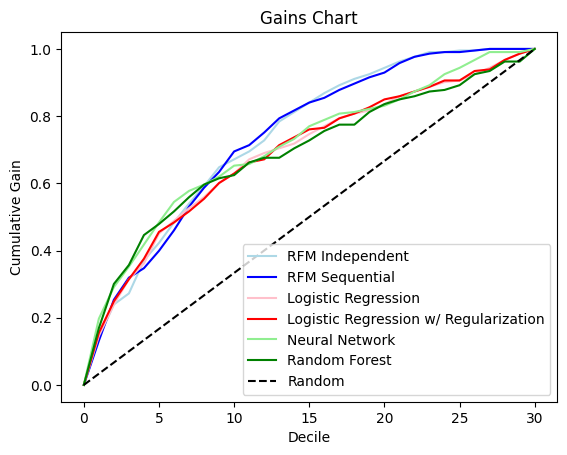

,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,73.97%,73.81%,68.72%,68.93%,70.88%,68.99%


,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,0.1986,0.1992,0.2088,0.2082,0.2036,0.2064


Dataset 2a


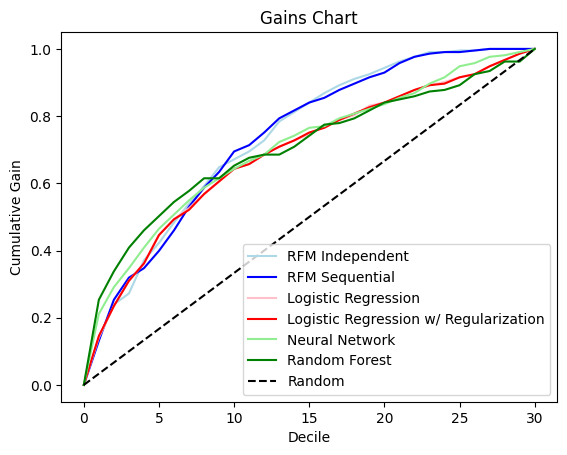

,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,73.97%,73.81%,68.87%,68.85%,70.41%,70.35%


,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,0.1986,0.1992,0.2085,0.2084,0.2040,0.2021


Dataset 2b


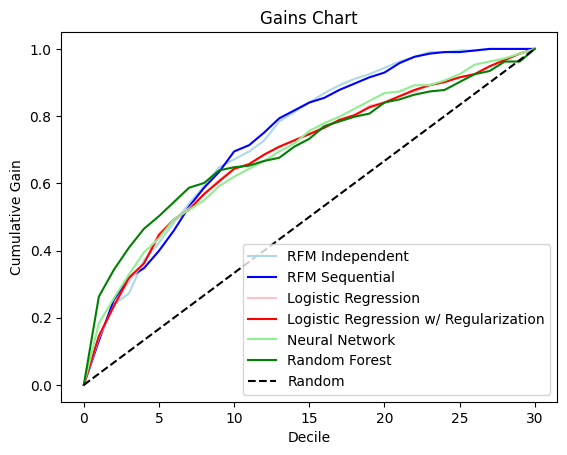

,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,73.97%,73.81%,68.85%,68.87%,69.43%,70.29%


,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,0.1986,0.1992,0.2086,0.2084,0.2069,0.2001


Dataset 3a


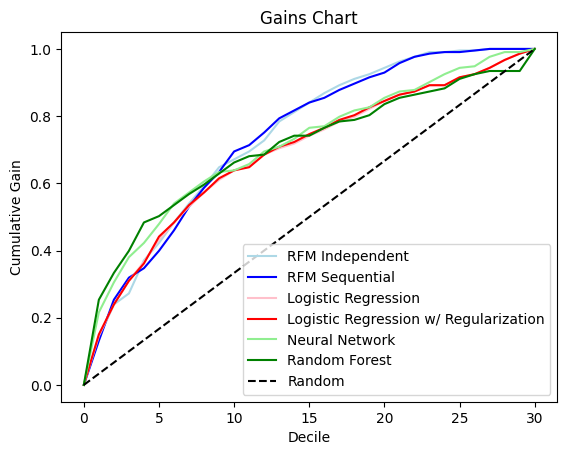

,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,73.97%,73.81%,68.66%,68.82%,71.15%,70.41%


,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,0.1986,0.1992,0.2087,0.2085,0.2020,0.2025


Dataset 3b


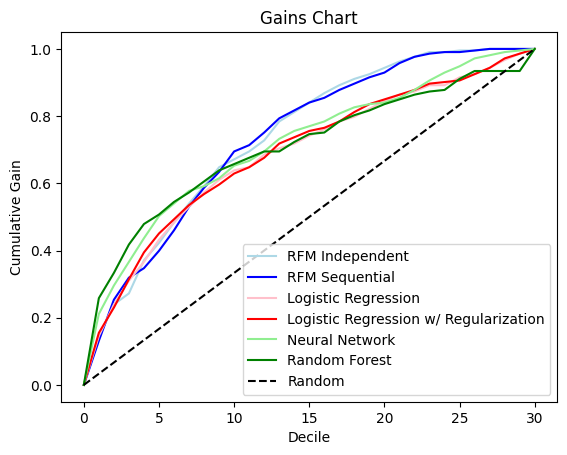

,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,73.97%,73.81%,68.65%,69.07%,71.53%,70.51%


,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,0.1986,0.1992,0.2088,0.2077,0.2022,0.2006


In [18]:
print("Dataset 1")
print_gains_performance(predictions1)
print("Dataset 2a")
print_gains_performance(predictions2a)
print("Dataset 2b")
print_gains_performance(predictions2b)
print("Dataset 3a")
print_gains_performance(predictions3a)
print("Dataset 3b")
print_gains_performance(predictions3b)
# print("Dataset 4")
# print_gains_performance(predictions4)

### c) Measure overfitting
We calculate overfitting as the difference in the AUC for each method when comparing gain AUC on the train and test datasets. We prefer models that have a smaller delta which indicates less overfitting.

In [19]:
# Define helper function to calculate and display overfitting
def calculate_overfitting(predictions, actuals):
    # Calculate gains on predictions and actuals
    gains_predict = evaluate_predictions(predictions)
    gains_actuals = evaluate_predictions(actuals)

    # Calculate gains AUC difference
    auc_predict = calculate_gains_auc(gains_predict)
    auc_actuals = calculate_gains_auc(gains_actuals)
    
    # Calculate differences
    gains_difference = gains_predict - gains_actuals
    auc_difference = auc_predict - auc_actuals
    
    # Display overfitting results
    gains_auc = auc_difference.style.format("{:.2%}")
    plot_gains_differences(gains_difference)
    display(gains_auc)

Dataset 1


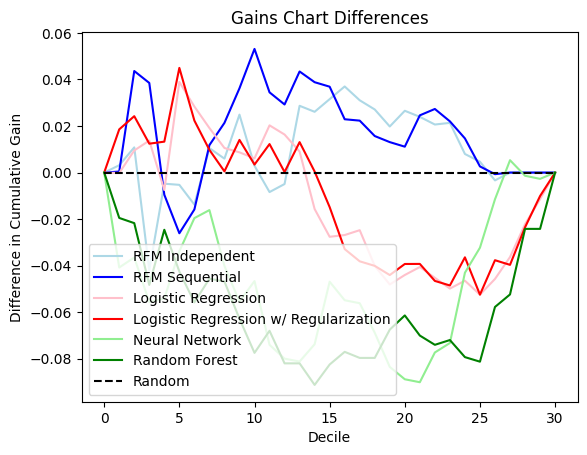

,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,0.94%,1.71%,-1.35%,-1.18%,-4.78%,-5.84%


Dataset 2a


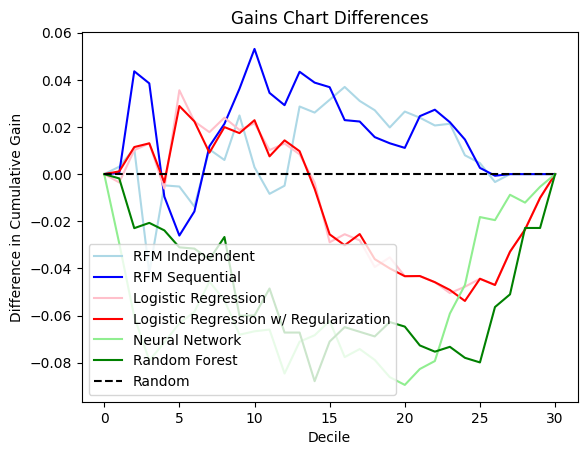

,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,0.94%,1.71%,-1.21%,-1.28%,-5.62%,-5.06%


Dataset 2b


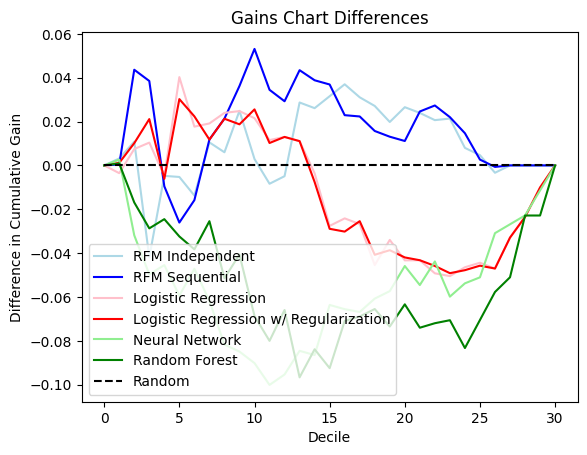

,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,0.94%,1.71%,-1.20%,-1.23%,-5.44%,-5.37%


Dataset 3a


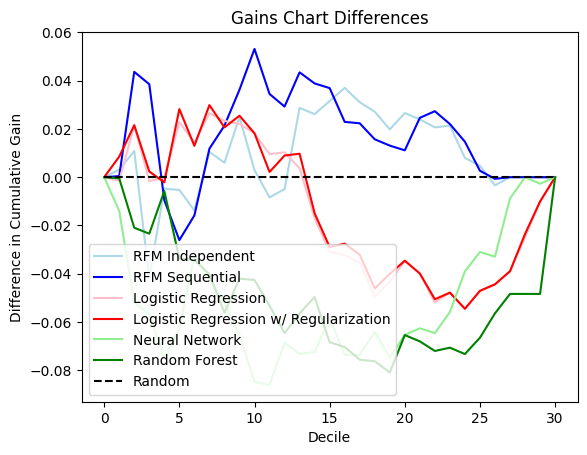

,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,0.94%,1.71%,-1.44%,-1.32%,-5.15%,-5.04%


Dataset 3b


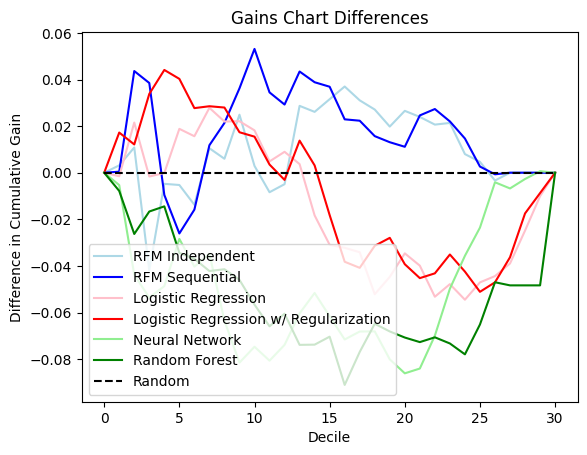

,rfm_i,rfm_s,logistic,logistic_reg,neural_net,random_forest
0,0.94%,1.71%,-1.49%,-0.80%,-4.84%,-5.30%


In [20]:
print("Dataset 1")
calculate_overfitting(predictions1, actuals1)
print("Dataset 2a")
calculate_overfitting(predictions2a, actuals2a)
print("Dataset 2b")
calculate_overfitting(predictions2b, actuals2b)
print("Dataset 3a")
calculate_overfitting(predictions3a, actuals3a)
print("Dataset 3b")
calculate_overfitting(predictions3b, actuals3b)
# print("Dataset 4")
# calculate_overfitting(predictions4, actuals4)

### d) Evaluate precision for models

In [21]:
from sklearn.metrics import confusion_matrix

# A function to calculate a model's recall, which will be used to determine how effective
# the model is at predicting true positives out of all its predictions
def calculate_precision(predictions, actuals):
    cm = confusion_matrix(actuals, predictions)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP_rate = TP / (TP+FP)
    return TP_rate

def evaluate_dataset_precision(test_data):
    precision_log = calculate_precision(test_data['res_log'], test_data['actual_res'])
    precision_logr = calculate_precision(test_data['res_logr'], test_data['actual_res'])
    precision_nn = calculate_precision(test_data['res_nn'], test_data['actual_res'])
    precision_rf = calculate_precision(test_data['res_rf'], test_data['actual_res'])
    precision_rfmi = calculate_precision(test_data['res_rfmi'], test_data['actual_res'])
    precision_rfms = calculate_precision(test_data['res_rfms'], test_data['actual_res'])

    return pandas.DataFrame({'logistic':precision_log, 
                             'logistic_reg':precision_logr, 
                             'neural_net':precision_nn, 
                             'random_forest':precision_rf,
                             'rfm_i':precision_rfmi,
                             'rfm_s':precision_rfms}, index=[0])

def print_precision(predictions):
    precision = evaluate_dataset_precision(predictions)
    precision_styled = precision.style.format("{:.2%}")
    display(precision_styled)
    return precision

In [22]:
# Calculate the precision for each model
print("Dataset 1")
precision1 = print_precision(predictions1)
print("Dataset 2a")
precision2a = print_precision(predictions2a)
print("Dataset 2b")
precision2b = print_precision(predictions2b)
print("Dataset 3a")
precision3a = print_precision(predictions3a)
print("Dataset 3b")
precision3b = print_precision(predictions3b)
# print("Dataset 4")
# precision4 = print_precision(predictions4)

Dataset 1


,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,9.84%,9.72%,11.16%,12.34%,9.93%,9.98%


Dataset 2a


,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,9.72%,9.73%,11.06%,13.11%,9.93%,9.98%


Dataset 2b


,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,9.71%,9.73%,10.15%,13.47%,9.93%,9.98%


Dataset 3a


,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,9.63%,9.63%,11.28%,12.64%,9.93%,9.98%


Dataset 3b


,logistic,logistic_reg,neural_net,random_forest,rfm_i,rfm_s
0,9.63%,9.32%,11.08%,13.23%,9.93%,9.98%


### e) Evaluate expected profits
Run scenario analysis to determine how much each model is expected to yield from profits

In [23]:
### A function to calculate the expected profit based on a set of predictions
### by 1) removing those who have already responded, 2) identifying those whose 
### predicted probability exceeds the threshold rate, 3) halving the predicted
### response rate, 4) calculating expected profit, and 5) subtracting the mail cost
def calculate_exp_profit(predictions, precision, field, population_size, threshold=breakeven_rate):
    # Remove people who have already responded
    second_wave_subset = predictions.loc[predictions['actual_res'] == 0]

    # Calculate the percent of people to target
    target_audience = second_wave_subset[second_wave_subset[field] > threshold]
    scaling_factor = population_size / len(second_wave_subset) # will use to scale up results

    # Calculate expected profit based on the predicted response rate (halved) times per-person profit
    # gross_profit = scaling_factor * (target_audience[field] * (per_person_profit)).sum()

    # Calculate expected profit based on the model's true-positive rate to avoid inflation
    gross_profit = scaling_factor * (precision.iloc[0] * len(target_audience)) * per_person_profit
    mail_cost = scaling_factor * len(target_audience) * per_person_mail_cost

    return [field, gross_profit - mail_cost, len(target_audience), len(second_wave_subset), 
            scaling_factor * len(target_audience), scaling_factor * len(second_wave_subset)]

### Calculate the expected profits across all the predictions
def evaluate_profits(predictions, precision, population_size, threshold=breakeven_rate):
    exp_rfmi = calculate_exp_profit(predictions, precision['rfm_i'], 'p_rfmi', population_size, threshold)
    exp_rfms = calculate_exp_profit(predictions, precision['rfm_s'], 'p_rfms', population_size, threshold)
    exp_log = calculate_exp_profit(predictions, precision['logistic'], 'p_log', population_size, threshold)
    exp_logr = calculate_exp_profit(predictions, precision['logistic_reg'], 'p_logr', population_size, threshold)
    exp_nn = calculate_exp_profit(predictions, precision['neural_net'], 'p_nn', population_size, threshold)
    exp_rf = calculate_exp_profit(predictions, precision['random_forest'], 'p_rf', population_size, threshold)

    transposed = [exp_rfmi, exp_rfms, exp_log, exp_logr, exp_nn, exp_rf]

    return pandas.DataFrame(transposed, columns=['Model', 'Expected Profit', 'Targeted People', 
                                                 'Eligible Sample', 'Targeted Population', 'Total Population'])

# Print results to console
def print_profit_performance(predictions, precision, population_size, threshold=breakeven_rate):
    profits = evaluate_profits(predictions, precision, population_size, threshold)
    profits = profits.style.format({'Expected Profit': '${:,.2f}',
                                        'Targeted People': '{:,.0f}',
                                        'Eligible Sample': '{:,.0f}',
                                        'Targeted Population': '{:,.0f}',
                                        'Total Population': '{:,.0f}'})
    display(profits)

Evaluate the models and determine the expected profitability for each model

In [24]:
# Run evaluation on datasets
total_population = 801821
wave_1_responders = 38487
mailing_population = total_population - wave_1_responders

print("Dataset 1")
print_profit_performance(predictions1, precision1, mailing_population, breakeven_rate)
print("Dataset 2a")
print_profit_performance(predictions2a, precision2a, mailing_population, breakeven_rate)
print("Dataset 2b")
print_profit_performance(predictions2b, precision2b, mailing_population, breakeven_rate)
print("Dataset 3a")
print_profit_performance(predictions3a, precision3a, mailing_population, breakeven_rate)
print("Dataset 3b")
print_profit_performance(predictions3b, precision3b, mailing_population, breakeven_rate)
# print("Dataset 4")
# print_profit_performance(predictions4, precision4, mailing_population, breakeven_rate)

Dataset 1


,Model,Expected Profit,Targeted People,Eligible Sample,Targeted Population,Total Population
0,p_rfmi,"$1,263,857.48","1,379","3,787","277,961","763,334"
1,p_rfms,"$1,348,439.83","1,461","3,787","294,489","763,334"
2,p_log,"$1,161,942.09","1,283","3,787","258,610","763,334"
3,p_logr,"$1,167,404.75","1,309","3,787","263,851","763,334"
4,p_nn,"$1,119,577.49","1,051","3,787","211,847","763,334"
5,p_rf,"$1,064,237.13",881,"3,787","177,580","763,334"


Dataset 2a


,Model,Expected Profit,Targeted People,Eligible Sample,Targeted Population,Total Population
0,p_rfmi,"$1,263,857.48","1,379","3,787","277,961","763,334"
1,p_rfms,"$1,348,439.83","1,461","3,787","294,489","763,334"
2,p_log,"$1,150,749.42","1,291","3,787","260,223","763,334"
3,p_logr,"$1,150,919.28","1,290","3,787","260,021","763,334"
4,p_nn,"$1,075,845.58","1,021","3,787","205,800","763,334"
5,p_rf,"$1,060,869.00",815,"3,787","164,277","763,334"


Dataset 2b


,Model,Expected Profit,Targeted People,Eligible Sample,Targeted Population,Total Population
0,p_rfmi,"$1,263,857.48","1,379","3,787","277,961","763,334"
1,p_rfms,"$1,348,439.83","1,461","3,787","294,489","763,334"
2,p_log,"$1,150,409.22","1,293","3,787","260,626","763,334"
3,p_logr,"$1,150,919.28","1,290","3,787","260,021","763,334"
4,p_nn,"$1,093,869.96","1,160","3,787","233,818","763,334"
5,p_rf,"$1,062,632.93",790,"3,787","159,238","763,334"


Dataset 3a


,Model,Expected Profit,Targeted People,Eligible Sample,Targeted Population,Total Population
0,p_rfmi,"$1,263,857.48","1,379","3,787","277,961","763,334"
1,p_rfms,"$1,348,439.83","1,461","3,787","294,489","763,334"
2,p_log,"$1,140,198.44","1,295","3,787","261,029","763,334"
3,p_logr,"$1,140,198.44","1,295","3,787","261,029","763,334"
4,p_nn,"$1,129,769.88","1,046","3,787","210,839","763,334"
5,p_rf,"$1,040,752.39",836,"3,787","168,510","763,334"


Dataset 3b


,Model,Expected Profit,Targeted People,Eligible Sample,Targeted Population,Total Population
0,p_rfmi,"$1,263,857.48","1,379","3,787","277,961","763,334"
1,p_rfms,"$1,348,439.83","1,461","3,787","294,489","763,334"
2,p_log,"$1,140,198.44","1,295","3,787","261,029","763,334"
3,p_logr,"$1,131,944.69","1,342","3,787","270,503","763,334"
4,p_nn,"$1,101,547.17","1,043","3,787","210,234","763,334"
5,p_rf,"$1,052,866.76",800,"3,787","161,254","763,334"
